https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import preliz as pz
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from pydantic import BaseModel, ConfigDict

pytensor.config.cxx = "/usr/bin/clang++"

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

Historical conversion rate mean: 0.024478721717384674
Historical conversion rate variance: 3.9923181217028725e-05


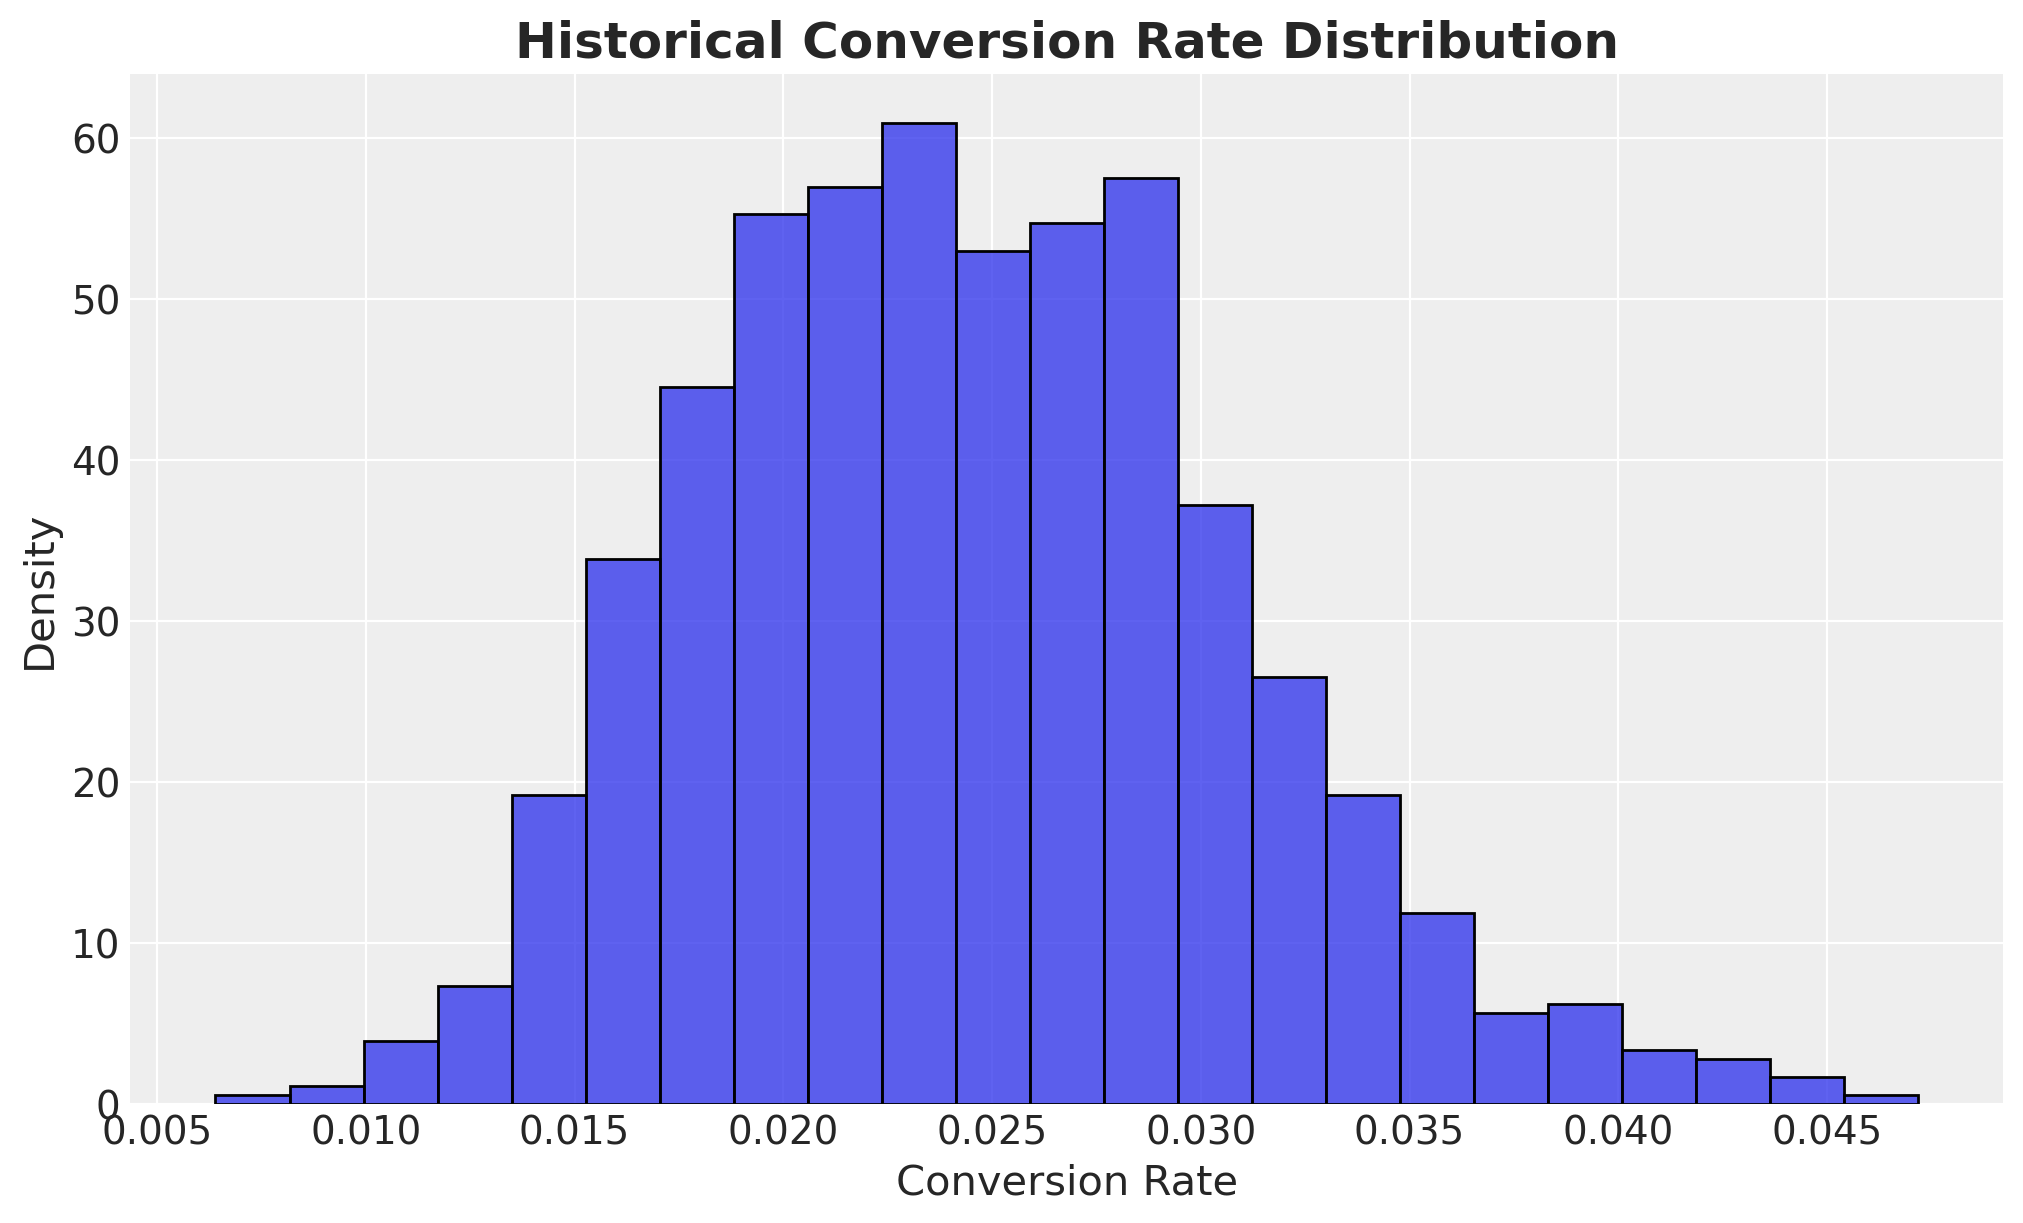

In [3]:
historical_conversions = pm.draw(
    pm.Beta.dist(alpha=15, beta=600), draws=1_000, random_seed=rng
)

fig, ax = plt.subplots()
sns.histplot(historical_conversions, stat="density", ax=ax)
ax.set(xlabel="Conversion Rate", ylabel="Density")
ax.set_title("Historical Conversion Rate Distribution", fontsize=18, fontweight="bold")
print(f"Historical conversion rate mean: {historical_conversions.mean()}")
print(f"Historical conversion rate variance: {historical_conversions.var()}")

In [4]:
(historical_conversions.var() * 16) / (0.002) ** 2

np.float64(159.6927248681149)

In [ ]:
class PowerAnalysisConfig(BaseModel):
    relative_lifts: npt.NDArray
    sample_sizes: npt.NDArray
    n_simulations: int
    rope: tuple[float, float]
    model_config = ConfigDict(arbitrary_types_allowed=True)


power_analysis_config = PowerAnalysisConfig(
    relative_lifts=np.linspace(-0.5, 0.5, 9),
    sample_sizes=np.linspace(100, 3_000, 15, dtype=int),
    n_simulations=500,
    rope=(-0.03 * 0.05, 0.03 * 0.05),
)

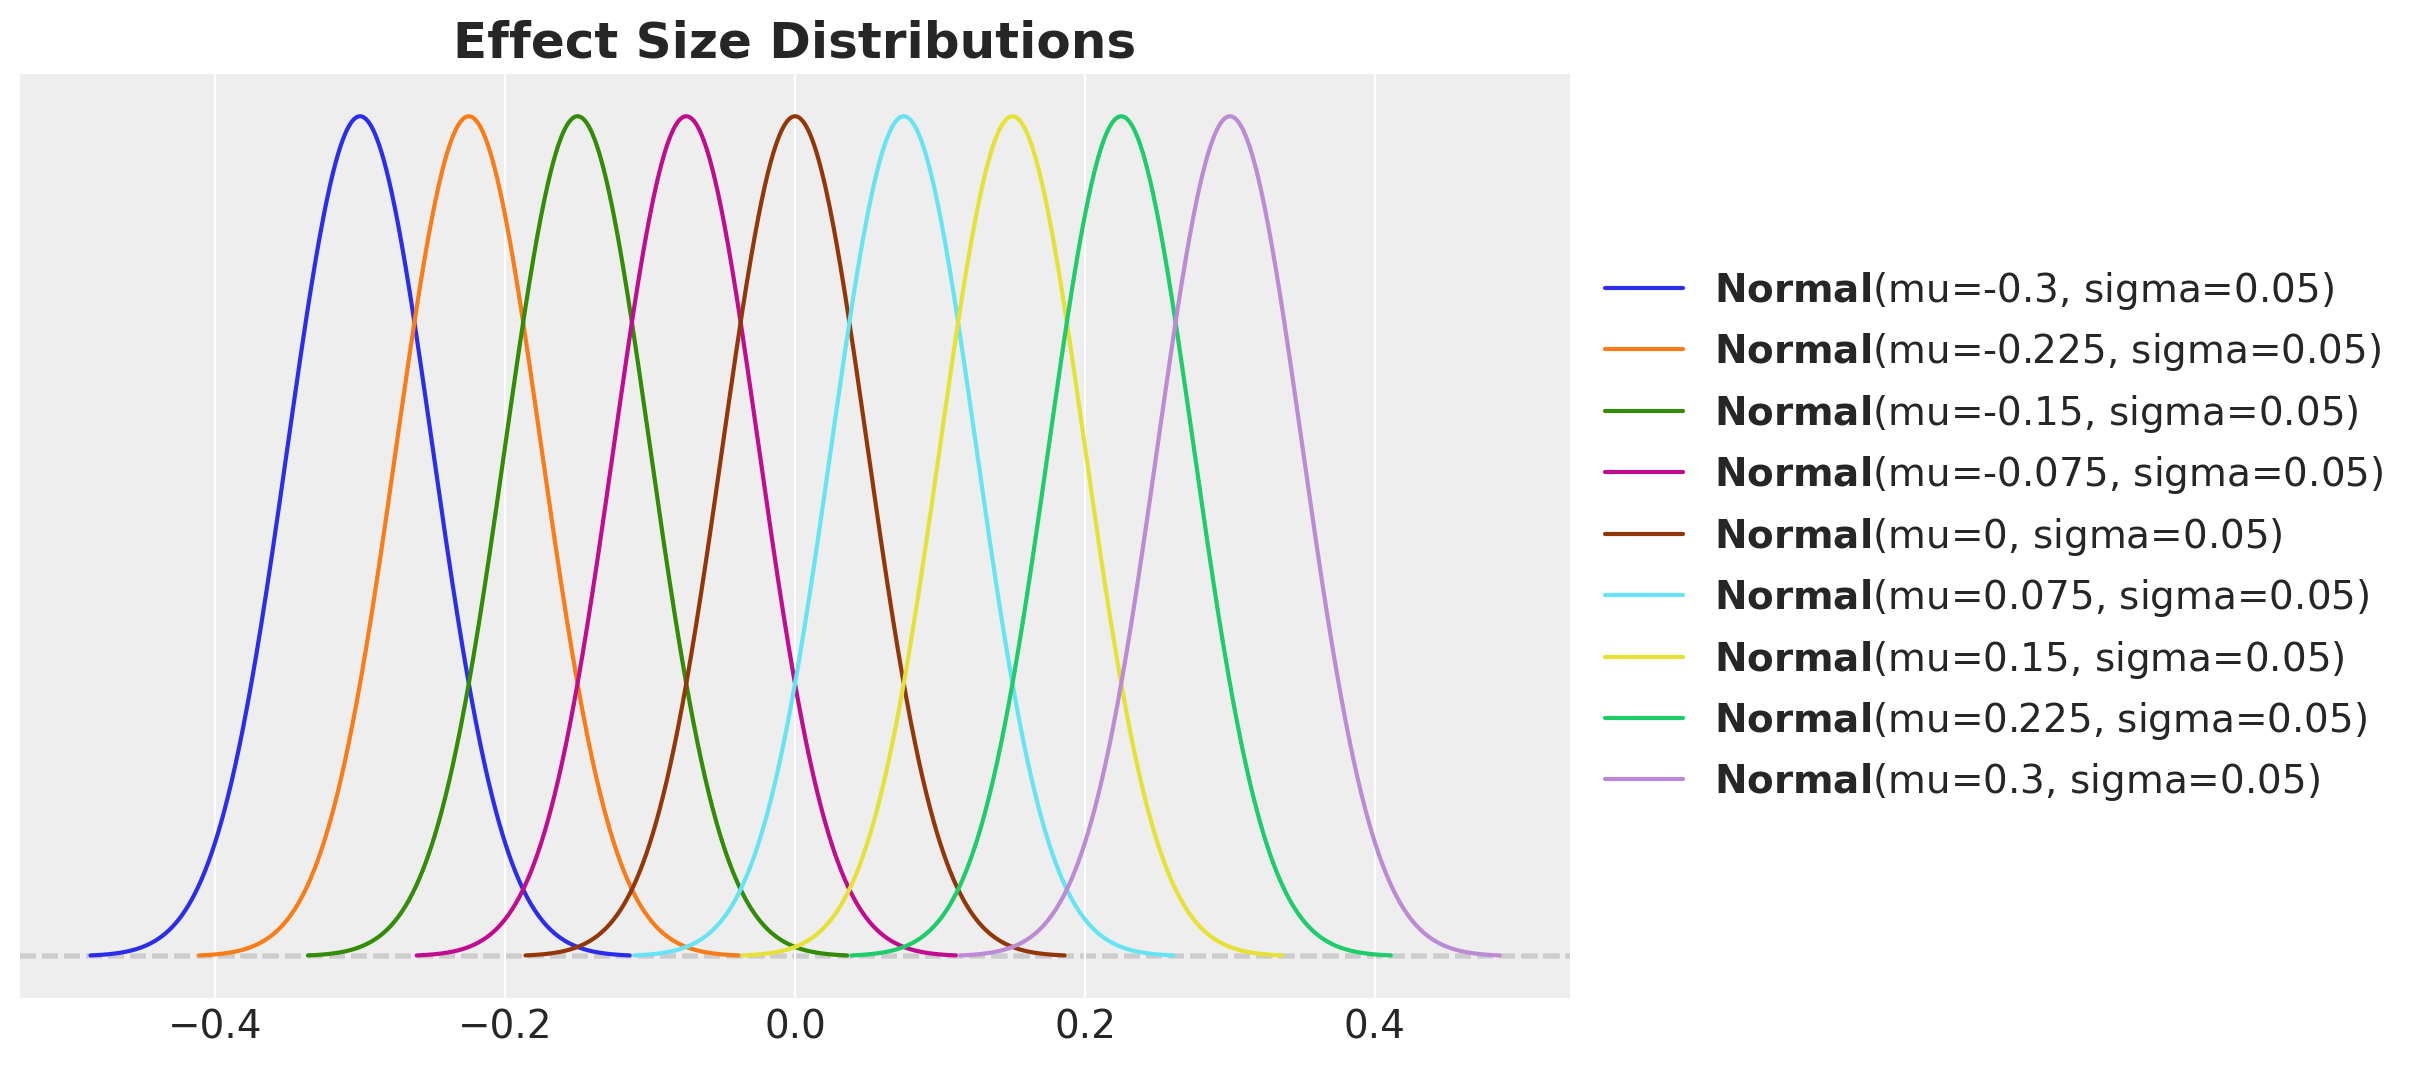

In [6]:
fig, ax = plt.subplots()

for relative_lift in power_analysis_config.relative_lifts:
    pz.Normal(mu=relative_lift, sigma=0.05).plot_pdf(ax=ax)

ax.set_title("Effect Size Distributions", fontsize=18, fontweight="bold");

Sampling: [conversion_rate_control, n_control, n_treatment, relative_lift]


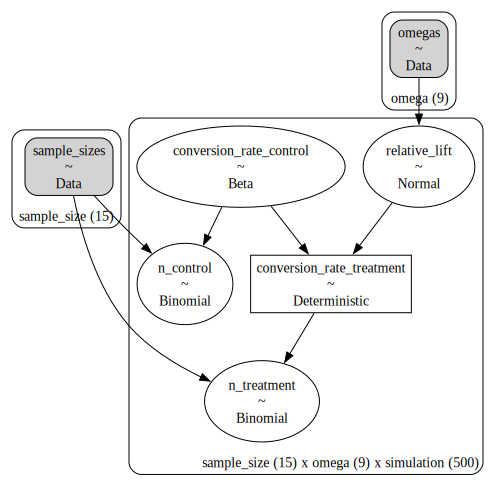

In [7]:
def generating_model_factory(
    power_analysis_config: PowerAnalysisConfig, rng: np.random.Generator
) -> tuple[az.InferenceData, pm.Model]:
    coords = {
        "sample_size": power_analysis_config.sample_sizes,
        "omega": power_analysis_config.relative_lifts,
        "simulation": range(power_analysis_config.n_simulations),
    }

    with pm.Model(coords=coords) as model:
        # Data container for the sample sizes we want to consider.
        sample_sizes_ = pm.Data(
            "sample_sizes",
            power_analysis_config.sample_sizes,
            dims=("sample_size",),
        )
        # Expand the sample sizes to the shape of the model.
        sample_sizes_expanded = pt.expand_dims(
            pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
        )
        # Data container for the omegas we want to consider.
        omegas_ = pm.Data(
            "omegas", power_analysis_config.relative_lifts, dims=("omega",)
        )
        # Expand the omegas to the shape of the model.
        omegas_expanded = pt.expand_dims(pt.as_tensor_variable(omegas_), axis=[0, 2])
        # Sample from the hypothetical distribution.
        relative_lift = pm.Normal(
            "relative_lift",
            mu=omegas_expanded,
            sigma=0.05,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_control = pm.Beta(
            "conversion_rate_control",
            alpha=15,
            beta=600,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_treatment = pm.Deterministic(
            "conversion_rate_treatment",
            conversion_rate_control * (1 + relative_lift),
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_control",
            n=sample_sizes_expanded,
            p=conversion_rate_control,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_treatment",
            n=sample_sizes_expanded,
            p=conversion_rate_treatment,
            dims=("sample_size", "omega", "simulation"),
        )

        idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

    return idata, model


generating_model_idata, data_generating_model = generating_model_factory(
    power_analysis_config=power_analysis_config, rng=rng
)

pm.model_to_graphviz(data_generating_model)

In [8]:
data_control = generating_model_idata["prior"]["n_control"].sel(chain=0, draw=0)
data_treatment = generating_model_idata["prior"]["n_treatment"].sel(chain=0, draw=0)

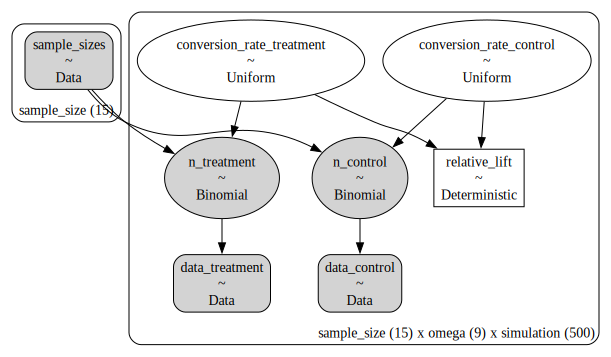

In [9]:
def get_non_informative_model(
    power_analysis_config: PowerAnalysisConfig,
    data_control: xr.DataArray,
    data_treatment: xr.DataArray,
) -> pm.Model:
    coords = {
        "sample_size": power_analysis_config.sample_sizes,
        "omega": power_analysis_config.relative_lifts,
        "simulation": range(power_analysis_config.n_simulations),
    }

    with pm.Model(coords=coords) as non_informative_model:
        sample_sizes_ = pm.Data(
            "sample_sizes",
            power_analysis_config.sample_sizes,
            dims=("sample_size",),
        )

        data_control_ = pm.Data(
            "data_control",
            data_control,
            dims=("sample_size", "omega", "simulation"),
        )

        data_treatment_ = pm.Data(
            "data_treatment",
            data_treatment,
            dims=("sample_size", "omega", "simulation"),
        )

        # Expand the sample sizes to the shape of the model.
        sample_sizes_expanded = pt.expand_dims(
            pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
        )

        conversion_rate_control = pm.Uniform(
            "conversion_rate_control",
            lower=0,
            upper=1,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_treatment = pm.Uniform(
            "conversion_rate_treatment",
            lower=0,
            upper=1,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Deterministic(
            "relative_lift",
            conversion_rate_treatment / conversion_rate_control - 1,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_control",
            n=sample_sizes_expanded,
            p=conversion_rate_control,
            observed=data_control_,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_treatment",
            n=sample_sizes_expanded,
            p=conversion_rate_treatment,
            observed=data_treatment_,
            dims=("sample_size", "omega", "simulation"),
        )

    return non_informative_model


non_informative_model: pm.Model = get_non_informative_model(
    power_analysis_config=power_analysis_config,
    data_control=data_control,
    data_treatment=data_treatment,
)

pm.model_to_graphviz(non_informative_model)

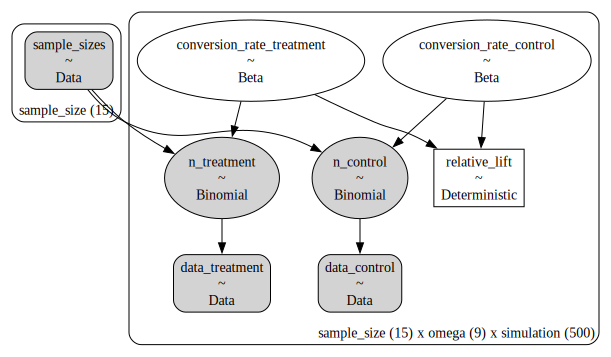

In [10]:
def get_informative_model(
    power_analysis_config: PowerAnalysisConfig,
    data_control: xr.DataArray,
    data_treatment: xr.DataArray,
) -> pm.Model:
    coords = {
        "sample_size": power_analysis_config.sample_sizes,
        "omega": power_analysis_config.relative_lifts,
        "simulation": range(power_analysis_config.n_simulations),
    }

    with pm.Model(coords=coords) as non_informative_model:
        sample_sizes_ = pm.Data(
            "sample_sizes",
            power_analysis_config.sample_sizes,
            dims=("sample_size",),
        )

        data_control_ = pm.Data(
            "data_control",
            data_control,
            dims=("sample_size", "omega", "simulation"),
        )

        data_treatment_ = pm.Data(
            "data_treatment",
            data_treatment,
            dims=("sample_size", "omega", "simulation"),
        )

        # Expand the sample sizes to the shape of the model.
        sample_sizes_expanded = pt.expand_dims(
            pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
        )

        conversion_rate_control = pm.Beta(
            "conversion_rate_control",
            alpha=15,
            beta=600,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_treatment = pm.Beta(
            "conversion_rate_treatment",
            alpha=15,
            beta=600,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Deterministic(
            "relative_lift",
            conversion_rate_treatment / conversion_rate_control - 1,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_control",
            n=sample_sizes_expanded,
            p=conversion_rate_control,
            observed=data_control_,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_treatment",
            n=sample_sizes_expanded,
            p=conversion_rate_treatment,
            observed=data_treatment_,
            dims=("sample_size", "omega", "simulation"),
        )

    return non_informative_model


informative_model: pm.Model = get_informative_model(
    power_analysis_config=power_analysis_config,
    data_control=data_control,
    data_treatment=data_treatment,
)

pm.model_to_graphviz(informative_model)

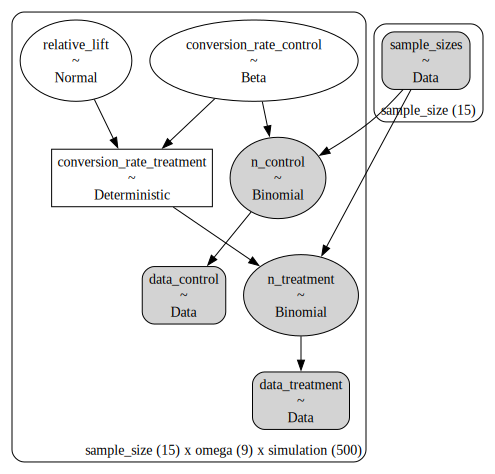

In [11]:
def get_correlated_model(
    power_analysis_config: PowerAnalysisConfig,
    data_control: xr.DataArray,
    data_treatment: xr.DataArray,
) -> pm.Model:
    coords = {
        "sample_size": power_analysis_config.sample_sizes,
        "omega": power_analysis_config.relative_lifts,
        "simulation": range(power_analysis_config.n_simulations),
    }

    with pm.Model(coords=coords) as non_informative_model:
        sample_sizes_ = pm.Data(
            "sample_sizes",
            power_analysis_config.sample_sizes,
            dims=("sample_size",),
        )

        data_control_ = pm.Data(
            "data_control",
            data_control,
            dims=("sample_size", "omega", "simulation"),
        )

        data_treatment_ = pm.Data(
            "data_treatment",
            data_treatment,
            dims=("sample_size", "omega", "simulation"),
        )

        # Expand the sample sizes to the shape of the model.
        sample_sizes_expanded = pt.expand_dims(
            pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
        )

        conversion_rate_control = pm.Beta(
            "conversion_rate_control",
            alpha=15,
            beta=600,
            dims=("sample_size", "omega", "simulation"),
        )

        relative_lift = pm.Normal(
            "relative_lift",
            mu=0,
            sigma=0.1,
            dims=("sample_size", "omega", "simulation"),
        )

        conversion_rate_treatment = pm.Deterministic(
            "conversion_rate_treatment",
            conversion_rate_control * (1 + relative_lift),
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_control",
            n=sample_sizes_expanded,
            p=conversion_rate_control,
            observed=data_control_,
            dims=("sample_size", "omega", "simulation"),
        )

        pm.Binomial(
            "n_treatment",
            n=sample_sizes_expanded,
            p=conversion_rate_treatment,
            observed=data_treatment_,
            dims=("sample_size", "omega", "simulation"),
        )

    return non_informative_model


correlated_model: pm.Model = get_correlated_model(
    power_analysis_config=power_analysis_config,
    data_control=data_control,
    data_treatment=data_treatment,
)

pm.model_to_graphviz(correlated_model)

In [12]:
%%time

with correlated_model:
    idata = pm.sample(
        draws=1_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 58min 56s, sys: 10min 35s, total: 1h 9min 32s
Wall time: 11min 47s


In [13]:
idata["posterior"]["relative_lift"].median(
    dim=["chain", "draw", "sample_size", "simulation"]
)

<xarray.DataArray 'relative_lift' (omega: 9)> Size: 72B
array([-0.05559303, -0.04102717, -0.02756906, -0.01348444,  0.00050372,
        0.01363437,  0.02585335,  0.03719126,  0.04950336])
Coordinates:
  * omega    (omega) float64 72B -0.3 -0.225 -0.15 -0.075 ... 0.15 0.225 0.3

In [14]:
hdi = az.hdi(idata["posterior"]["relative_lift"], hdi_prob=0.95)["relative_lift"]

In [15]:
results = (
    (hdi.sel(hdi="lower") > power_analysis_config.rope[1])
    | (hdi.sel(hdi="higher") < power_analysis_config.rope[0])
).mean(dim="simulation")

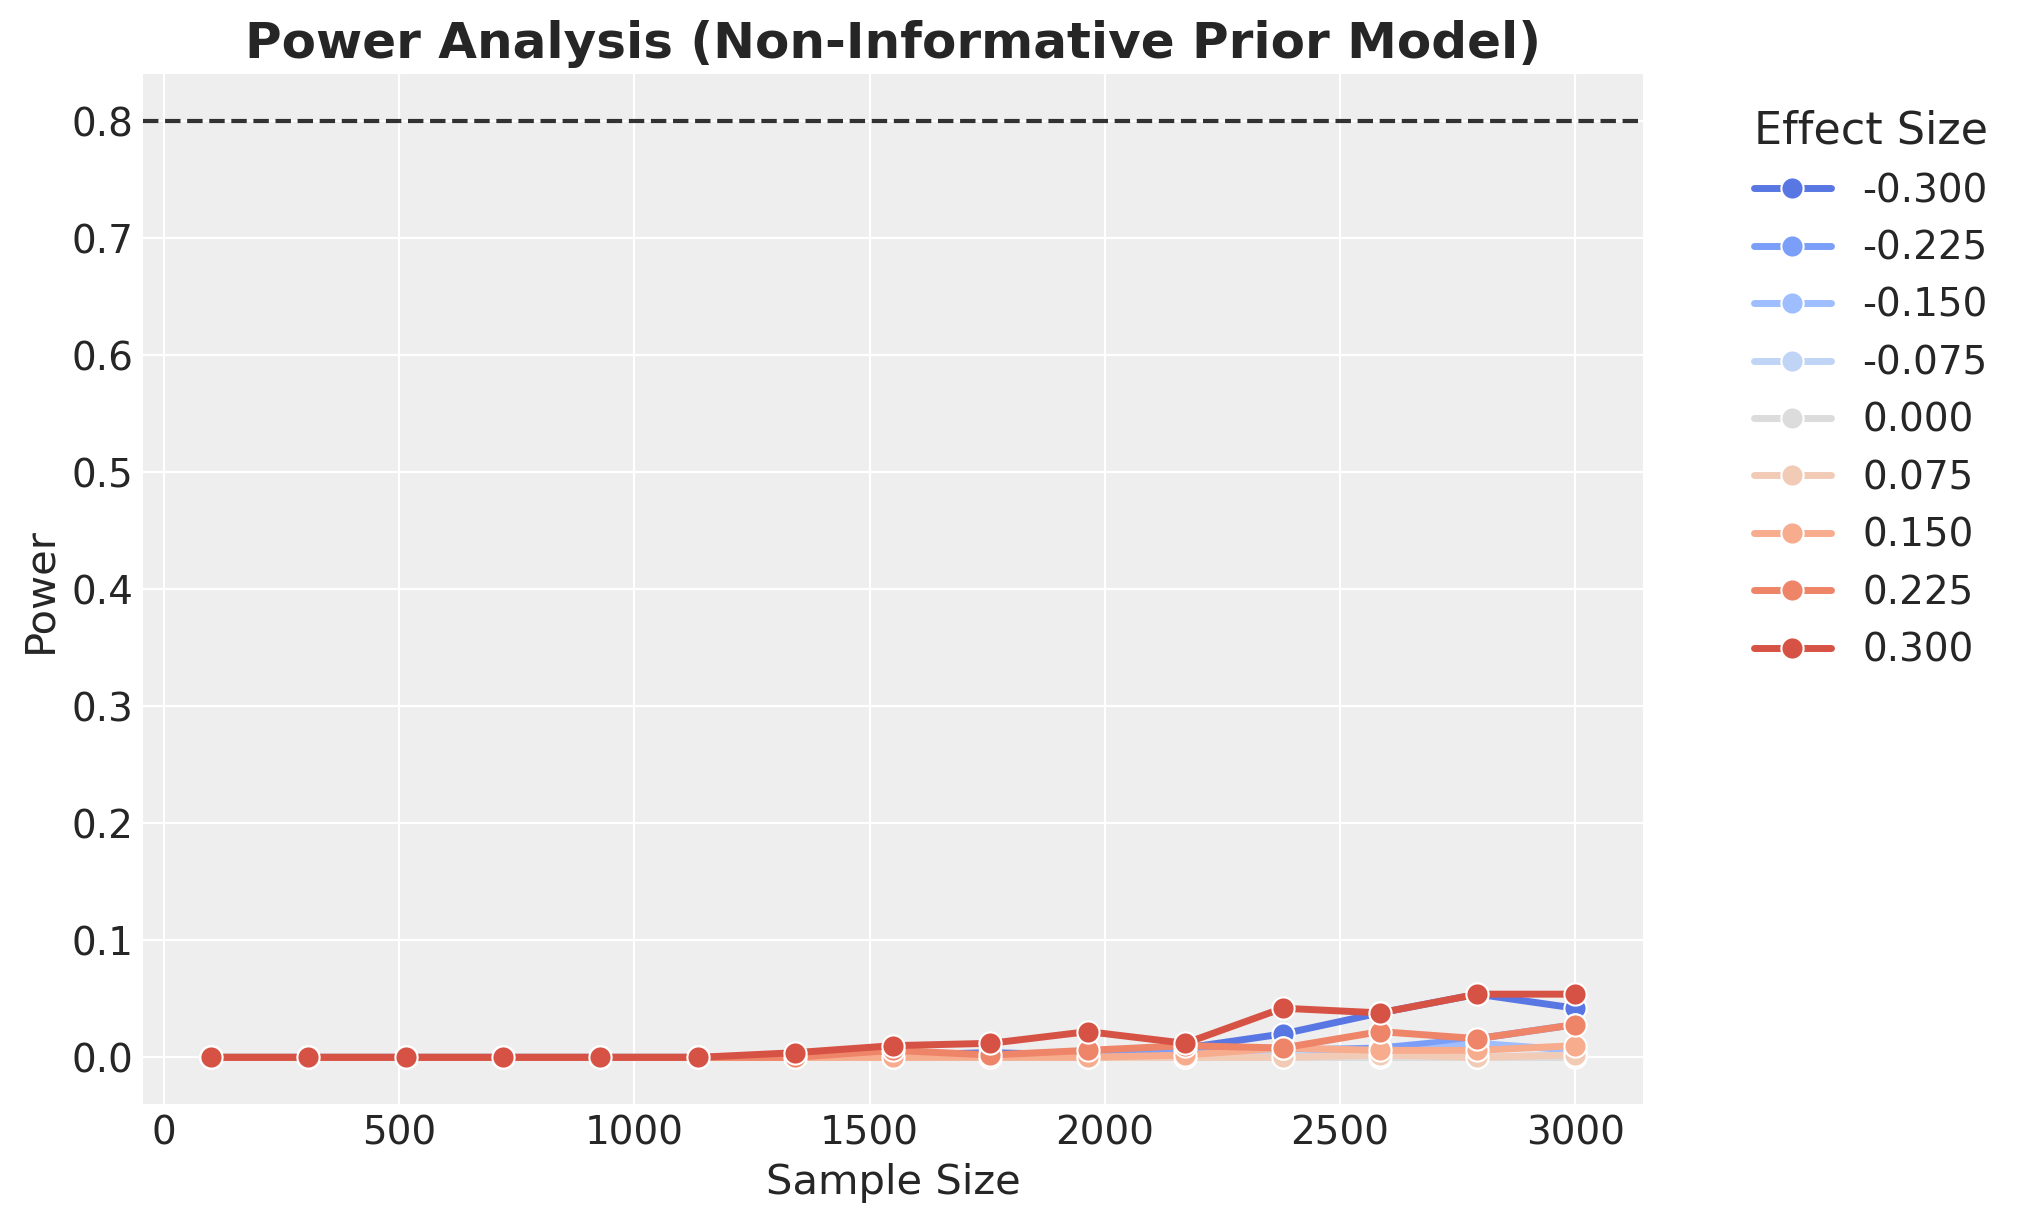

In [16]:
fig, ax = plt.subplots()

sns.lineplot(
    data=(
        results.to_dataframe()
        .reset_index(drop=False)
        .assign(omega=lambda x: x["omega"].astype("str"))
    ),
    x="sample_size",
    y="relative_lift",
    hue="omega",
    marker="o",
    markersize=8,
    linewidth=2.5,
    palette=sns.color_palette(
        "coolwarm", n_colors=len(power_analysis_config.relative_lifts)
    ),
    ax=ax,
)

ax.axhline(0.8, color="black", linestyle="--", alpha=0.8)

handles, labels = ax.get_legend_handles_labels()
rounded_labels = [f"{float(label):.3f}" for label in labels]
ax.legend(
    handles,
    rounded_labels,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Effect Size",
    title_fontsize=16,
)
ax.set(xlabel="Sample Size", ylabel="Power")
ax.set_title(
    "Power Analysis (Non-Informative Prior Model)", fontsize=18, fontweight="bold"
);